In [ ]:
# Incase we have to clear all variables
%reset -f

In [1]:
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061']

from dimer_setup import *
from utils import *

In [2]:
import matplotlib.pyplot as plt
from heatmap_setup import calculate_steadystate
from scipy.sparse.linalg import eigs, lgmres
from scipy.sparse import csc_matrix
import time
import numpy as np

### Example Liouvillian

In [9]:
w_2 = 1.4*ev_to_inv_cm
bias = 0.1*ev_to_inv_cm
V = 0.001*ev_to_inv_cm
alpha = 500/pi
alpha_EM = 5.309e-3
N = 4
pap = alpha_to_pialpha_prop(alpha, w_2)
wc = 100.
w_0 = 200.
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, pialpha_prop=pap,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)

H, L = get_H_and_L(PARAMS, silent=False, threshold=1e-7)

The operators took 2.10646915436 and have dimension 64.
Building the RC Liouvillian took 2.216 seconds.
****************************************************************
It is 4096by4096. The full basis would be 4096by4096
It took  1.42421293259  seconds to build the Non-secular RWA Liouvillian


In [10]:
H, L = get_H_and_L(PARAMS, silent=False, threshold=1e-7, site_basis=True)

print sparse_percentage(qt.liouvillian(H[1], [L]))
H, L = get_H_and_L(PARAMS, silent=False, threshold=1e-7, site_basis=False)
print sparse_percentage(qt.liouvillian(H[1], [L]))

The operators took 2.38373613358 and have dimension 64.
Building the RC Liouvillian took 2.494 seconds.
****************************************************************
It is 4096by4096. The full basis would be 4096by4096
It took  1.39832806587  seconds to build the Non-secular RWA Liouvillian
7.26307630539
The operators took 1.80441999435 and have dimension 64.
Building the RC Liouvillian took 2.437 seconds.
****************************************************************
It is 4096by4096. The full basis would be 4096by4096
It took  2.35509705544  seconds to build the Non-secular RWA Liouvillian
15.2484536171


In [ ]:
ti = time.time()
ssL, info = calculate_steadystate(H, L, method="eigen", persistent=False)
print time.time()-ti; ti = time.time()


In [ ]:
expectation(ssL)

In [ ]:
from scipy.sparse.linalg import eigs
from qutip.cy.spconvert import dense2D_to_fastcsr_fmode

def v0_estimate(H, PARAMS, method=0):
    H = H[1]
    T1, T2 = PARAMS['T_EM'], 0.5*(PARAMS['T_1']+PARAMS['T_2'])
    alpha1, alpha2 = PARAMS['alpha_EM'], 0.5*(PARAMS['alpha_1']+PARAMS['alpha_2'])
    p1 = alpha1/(alpha1+alpha2)
    p2 = alpha2/(alpha1+alpha2)
    p1/= (p1+p2)
    p2/= (p1+p2)
    if method==1:
        # Average two density matrices together
        r1 = (-beta_f(T1)*H).expm(method='sparse')
        r2 = (-beta_f(T2)*H).expm(method='sparse')
        rho_approx = r1#+r2
        return qt.operator_to_vector(rho_approx/rho_approx.tr()).data.todense()
    elif method==0:
        # Averages temperatures
        r1 = (-beta_f(abs(2*T1-T2))*H).expm(method='sparse')
        return qt.operator_to_vector(r1/r1.tr()).data.todense()
    else:
        r1 = (-beta_f(T1)*H).expm(method='sparse')
        r2 = (-beta_f(T2)*H).expm(method='sparse')
        rho_approx = 0.5*(r1+r2)+(-beta_f(abs(2*T1-T2))*H).expm(method='sparse')
        return qt.operator_to_vector(rho_approx/rho_approx.tr()).data.todense()

def expectation(rho, expval='site_coherence'):
    e_op = make_expectation_operators(PARAMS)[expval]
    return (rho*e_op).tr()

def vec_to_dm(evec, _H):
    n = int(np.sqrt(evec.shape[0]))
    data = dense2D_to_fastcsr_fmode(evec.reshape((n, n)).T, n, n)
    data = 0.5 * (data + data.H)
    data = qt.Qobj(data, dims=_H[1].dims, isherm=True)
    return data/data.tr()



def _steadystate(H, L, tol=1e-8, sigma=1e-12, ncv=18, print_coh=True, v0=None):
    L_full = -1*qt.liouvillian(H[1], c_ops=[L]).data
    ti = time.time()
    evals, evec = eigs(L_full, 1, which='LM', sigma=sigma, tol=tol, ncv=ncv, v0=v0)
    print("Steadystate took {:0.3f} seconds".format(time.time() - ti))
    rho = vec_to_dm(evec, H)
    if print_coh:
        print("Coherence is {}".format(expectation(rho)))
    return rho

In [ ]:
#ev, evec = H[1].
from scipy.linalg import eig, inv
import numpy as np
def sorted_eig(_H):
    if type(_H) == qt.Qobj:
        _H = _H.full()
    eigenValues, eigenVectors = eig(_H)
    idx = eigenValues.argsort()[::-1]   
    return eigenValues[idx], eigenVectors[:,idx]

def to_eigenbasis(op, evals, evecs, evecs_inv):
    if type(op) == qt.Qobj:
        op = op.full()
    A = np.matmul(evecs_inv, op)
    return np.matmul(A, evecs)

def to_site_basis(op, evals, evecs, evecs_inv):
    if type(op) == qt.Qobj:
        op = op.full()
    A = np.matmul(evecs, op)
    return np.matmul(A, evecs_inv)

def array_to_qobj(arr, qobj_in_basis):
    return qt.Qobj(arr, dims=qobj_in_basis.dims)
#print H[1]
eVals, eVecs = H[1].eigenstates()
evecs = np.transpose(np.array([v.dag().full()[0] for v in eVecs]))

#evals, evecs = sorted_eig(H[1])
ti = time.time()
evecs_inv = inv(evecs)
print (time.time() - ti)
D = to_eigenbasis(H[1], evals, evecs, evecs_inv)
H_again = to_site_basis(qt.Qobj(D), evals, evecs, evecs_inv)

assert np.sum(np.around(sorted_eig(qt.Qobj(H_array))[0]-sorted_eig(qt.Qobj(D))[0], 3)) == 0. # get diagonal
assert np.sum(np.around(H_again - H_array, 3)) == 0. # get H again from diagonal

print np.sum(D)
print np.sum(H[1].transform(eVecs).full())

In [ ]:
v0 = v0_estimate(H, PARAMS, method=0)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0, method="eigen")

In [ ]:
v0 = v0_estimate(H, PARAMS, method=1)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0)

In [ ]:
v0 = v0_estimate(H, PARAMS, method=2)
print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=v0)

In [ ]:
#v0 = v0_estimate(H, PARAMS, method=0)
#print(np.sum(abs(vec_to_dm(v0, H)-ssL)))
rho = _steadystate(H, L, v0=None)

In [ ]:
visualise_sparse(L)
visualise_sparse(L_tidy)

In [ ]:
print nonzero_elements(L)
print nonzero_elements(L_tidy)
print total_elements(L)
print 100*float(nonzero_elements(L))/total_elements(L)
print 100*float(nonzero_elements(L_tidy))/total_elements(L)

In [ ]:
print "Total error per nz dm element due to chop: {}".format(np.sum(ssL.full()-ssLt.full())/nonzero_elements(ssL)) 

visualise_dense(ssL)
visualise_dense(ssLt)


# For N=6, with no 

In [ ]:
"""from heatmap_setup import steadystate

w_2 = 8000.
alpha = 20.

N = 6
pap = alpha_to_pialpha_prop(alpha, w_2)
PARAMS = PARAMS_setup(bias=100., w_2=8000., V = 100., pialpha_prop=pap,
                                 T_EM=6000., T_ph =300.,
                                 alpha_EM=0.1, shift=True,
                                 num_cpus=3, N=N, Gamma=200., w_0=300.,
                                 silent=True, exc_diff=0)
from numpy.linalg import norm
def estimateCondition(M):
    vec = np.ones((1, M.shape[0])).T
    return norm(M.dot(vec), np.inf)"""

The operators took 0.341955900192 and have dimension 16.
Building the RC Liouvillian took 0.346 seconds.
****************************************************************
It is 256by256. The full basis would be 256by256
It took  0.251564979553  seconds to build the Non-secular RWA Liouvillian
direct 0.00396990776062
power 0.00395393371582
eigen 0.00724816322327
The operators took 1.0949549675 and have dimension 36.
Building the RC Liouvillian took 1.111 seconds.
****************************************************************
It is 1296by1296. The full basis would be 1296by1296
It took  0.896306037903  seconds to build the Non-secular RWA Liouvillian
direct 0.106192111969
power 0.388214111328
eigen 0.422070026398
The operators took 2.20498800278 and have dimension 64.
Building the RC Liouvillian took 2.370 seconds.
****************************************************************
It is 4096by4096. The full basis would be 4096by4096
It took  1.39429998398  seconds to build the Non-secular

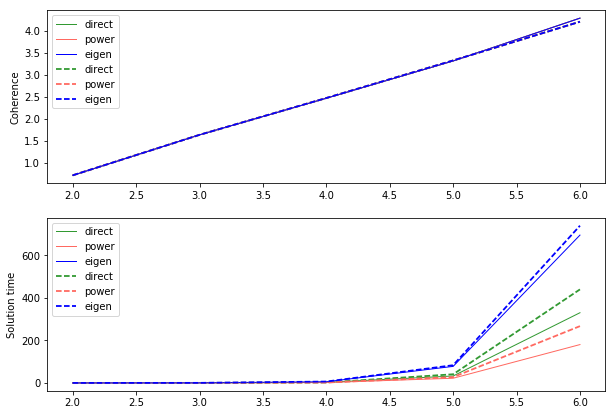

In [7]:
from qutip import build_preconditioner

def method_plotter(N_vals, data_dict, info_dict, ax1, ax2, linestyle="solid"):
    lw=1.
    if linestyle == 'dashed':
        lw=1.8
    for i, key in enumerate(data_dict.keys()):
        ax1.plot(N_vals, data_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
        #print info_dict[key]
        ax2.plot(N_vals, info_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
    ax1.legend()
    ax2.legend()
    ax1.set_ylabel("Coherence")
    ax2.set_ylabel("Solution time")


def method_comparison(N_i, N_f, plot=False, site_basis=True):
    methods = ['direct','power', 'eigen']
    data_dict = dict()
    info_dict = dict()
    N_vals = range(N_i, N_f)
    for N in N_vals:
        PARAMS.update({'N_1':N, 'N_2':N, 'exc':int(2*N)})
        H, L = get_H_and_L(PARAMS,silent=False, threshold=1e-7, site_basis=site_basis)
        exps = make_expectation_operators(H, PARAMS, site_basis=site_basis)
        for method in methods:
            try:
                M=None
                """ 
                if "iterative" in method:
                    ti = time.time()
                    M = build_preconditioner(H[1], [L], fill_factor=1000,
                                           drop_tol=1e-4, use_rcm=True, ILU_MILU='smilu_2')
                    print "Building preconditioner ({}) took {} seconds".format(estimateCondition(M), 
                                                                                     time.time()-ti)"""
                ss, full_info = steadystate(H[1], [L], method=method, M=M,
                                           use_precond=True, use_rcm=True, 
                                           return_info=True, tol=1e-8, maxiter=5000)

                print method, full_info['solution_time']
                info = full_info['solution_time']

                coh = (exps['sigma_x']*ss).tr()
                try:
                    data_dict[method].append(coh)
                    info_dict[method].append(info)
                except KeyError:
                    data_dict[method] = [coh]
                    info_dict[method] = [info]
            except Exception as err:
                print "{} failed due to : {}".format(method, err)
                try:
                    data_dict[method].append(None)
                    info_dict[method].append(None)
                except KeyError:
                    data_dict[method] = [None]
                    info_dict[method] = [None]
    #if plot:
    #    method_plotter(N_vals, data_dict, info_dict)
    return N_vals, data_dict, info_dict

N_vals, data_dict_sb, info_dict_sb = method_comparison(2,7)
N_vals, data_dict_eb, info_dict_eb = method_comparison(2,7, site_basis=False)

f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7))
method_plotter(N_vals, data_dict_sb, info_dict_sb, ax1, ax2)
method_plotter(N_vals, data_dict_eb, info_dict_eb, ax1, ax2, linestyle="dashed")
plt.show()

# Plotting methods

In [ ]:
def steadystate_observable(ss_array, PARAMS, observable):
    try:
        size = (len(PARAMS['y_values']), len(PARAMS['x_values']))
    except KeyError:
        size = (1,1)
    # deal with the case where N is being changed as an x value
    if 'N_1' in PARAMS['x_axis_parameters']:
        data_array = np.zeros(size)         # Collect data
        N_values = PARAMS['x_values']
        # NEw observable operator for each N value
        for i, N in enumerate(N_values):
            PARAMS.update({'N_1' : N, 'N_2' : N})
            exc = N+PARAMS['exc_diff']
            # Leave it so exc can be fixed or a y_parameter
            if 'exc' in PARAMS['x_axis_parameters']:
                PARAMS.update({'exc': exc})
            _obs_op = make_expectation_operators(PARAMS)[observable]
            for j, y in enumerate(PARAMS['y_values']):
                # the case where exc is on the y axis
                if 'exc_diff' in PARAMS['y_axis_parameters']:
                    PARAMS.update({'exc': N+y})
                    _obs_op = make_expectation_operators(PARAMS)[observable]
                try:
                    print ss_array[j][i].shape, _obs_op.shape
                    data_array[j][i] = (qt.Qobj(ss_array[j][i])*_obs_op).tr().real
                except AttributeError:
                    data_array[j][i] = np.nan
        return data_array
    else:
        # Much simpler if N isn't on the x-axis
        obs_op = make_expectation_operators(PARAMS)[observable]
        f = lambda x: (qt.Qobj(x)*obs_op).tr()
        ss_array = np.reshape(ss_array, (1, size[0]*size[1]))[0]

        data_array = map(f, ss_array)
        data_array = np.array(data_array).reshape(size).real
        return data_array


def heatmap_plotter(num, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True):
    
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    info = info_array[0][0]
    
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "new style"
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.)
    
    ss_array = steadystate_observable(ss_array, PARAMS, observable)

    
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for i, y_val in enumerate(PARAMS['y_values']):
        x_values = PARAMS['x_values']
        if reverse_x:
            x_values = x_values[::-1]
        axes.plot(x_values, ss_array[i], 
                  label=str(PARAMS['y_axis_parameters'])+"="+str(y_val))
    
    print_PARAMS(PARAMS)
    
    plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
    plt.ylabel("Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    plt.grid()
    plot_filename = 'PLOTS/'+dir_name+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename)
    print "saved at {}".format(plot_filename)
    plt.show()

In [ ]:
heatmap_plotter(2, plot_SD=False, dir_name='heatmap_excvN', 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True)